Este es un proyecto de reconocimiento de imágenes mediante el uso de una red neuronal convolusional o CNN. A tal fin, creo un set con fotos de tornillos y tarugos plásticos (para fijación en muros). Luego se hace un preprocesado de las imágenes, se arma la estructura de la CNN y se entrena para su posterior prueba clasificando. El set de imágenes se deja en el repositorio así, aquel que desee probar su funcionamiento, pueda hacerlo sin problemas.

In [1]:
# Importamos las librerías necesarias:

from __future__ import absolute_import, division, print_function, unicode_literals

variable_name = ""
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import sys
import zipfile
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import math
import os
import io
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.python.keras.layers import  Convolution2D, Activation
from tensorflow.python.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report,  mean_squared_error, r2_score, plot_confusion_matrix

print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.8.2


In [2]:
# Subimos el archivo .Zip con las imágenes:

from google.colab import files
upfiles = files.upload()

Saving SET_CNN.zip to SET_CNN.zip


In [3]:
# Descomprimimos el archivo:

data = zipfile.ZipFile(io.BytesIO(upfiles['SET_CNN.zip']),'r')
data.extractall()

In [4]:
# Creamos una lista con las imágenes de la carpeta "tornillos" (si queremos podemos
# convertir las imágenes a escala de grises), reescalamos el tamaño de las mismas
# y la transformamos en un array de numpy:

path_tor = '/content/tornillos/'
list_tor = []
size_tor = 150

for Tornis in os.listdir(path_tor):
  Tornis = cv2.imread(os.path.join(path_tor,Tornis))
  resize_Tornis = cv2.resize(Tornis,(size_tor,size_tor))
  list_tor.append(resize_Tornis)

# Si quisieramos pasar las imágenes a escala de grises, usamos este otro ciclo for:
#for Tornis in os.listdir(path_tor):
#  Tornis = cv2.imread(os.path.join(path_tor,Tornis))
#  gray_Tornis = cv2.cvtColor(Tornis,cv2.COLOR_BGR2GRAY)
#  gray_resize_Tornis =cv2.resize(gray_Tornis,(tor_size,tor_size))
#  list_tor.append(gray_resize_Tornis)

list_tor = np.array(list_tor)

# Vemos como quedó:

print("Tamaño lista Tornillos:",len(list_tor))
print(list_tor.shape)

Tamaño lista Tornillos: 90
(90, 150, 150, 3)


In [5]:
# Creamos una lista con las imágenes de la carpeta "tarugos" (si queremos podemos
# convertir las imágenes a escala de grises), reescalamos el tamaño de las mismas
# y la transformamos en un array de numpy:

path_tar = '/content/tarugos/'
list_tar = []
size_tar = 150

for Tarug in os.listdir(path_tar):
  Tarug = cv2.imread(os.path.join(path_tar,Tarug))
  resize_Tarug = cv2.resize(Tarug,(size_tar,size_tar))
  list_tar.append(resize_Tarug)

# Si quisieramos pasar las imágenes a escala de grises, usamos este otro ciclo for:
#for Tarug in os.listdir(path_tar):
#  Tarug = cv2.imread(os.path.join(path_tar,Tarug))
#  gray_Tarug = cv2.cvtColor(Tarug,cv2.COLOR_BGR2GRAY)
#  gray_resize_Tarug =cv2.resize(gray_Tarug,(tar_size,tar_size))
#  list_tar.append(gray_resize_Tarug)

list_tar = np.array(list_tar)

# Vemos como quedó:

print("Tamaño lista Tarugos:",len(list_tar))
print(list_tar.shape)

Tamaño lista Tarugos: 90
(90, 150, 150, 3)


In [6]:
# Unimos ambos conjuntos de imágenes:

dataImg = np.concatenate([list_tor,list_tar])
print(len(dataImg))
print(dataImg.shape)

180
(180, 150, 150, 3)


In [7]:
# Creamos la etiqueta "TORNILLO" para las imágenes de tornillos:

label_tor = np.repeat(0,90)
print(len(label_tor))
print(label_tor)

# Creamos la etiqueta "TARUGO" para las imágenes de tarugos:

label_tar = np.repeat(1,90)
print(len(label_tar))
print(label_tar)

# Definimos las clases:

class_names = ['TORNILLO','TARUGO']

# Teniendo en cuenta el orden de las etiquetas, las unimos:

labels = np.concatenate([label_tor,label_tar])
print(len(labels))
print(labels)

# Convertimos "labels" en un array:
Labels = np.array(labels)
print(Labels.shape)

90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
180
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(180,)


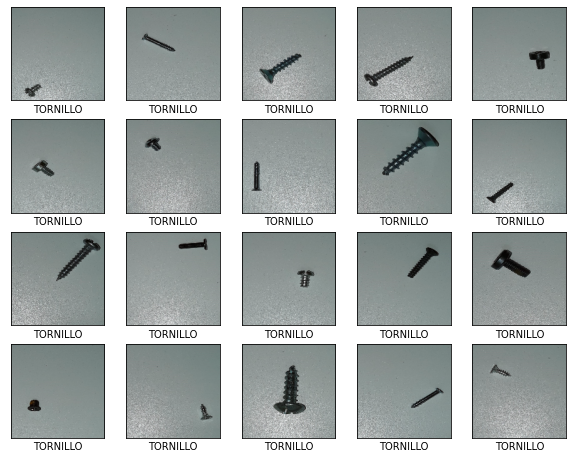

In [8]:
# Comprobamos con algunas imágenes que éstas ya tienen sus respectivas etiquetas:

plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(dataImg[i])
  cmap = plt.cm.binary
  plt.xlabel(class_names[Labels[i]])
plt.show()

In [9]:
# Separamos el set en conjuntos de entrenamiento y validación:

X_train, X_test, y_train, y_test = train_test_split(dataImg, Labels, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(144, 150, 150, 3)
(36, 150, 150, 3)
(144,)
(36,)


In [28]:
# Creamos el modelo de red neuronal convulsional:

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
cnn.add(tf.keras.layers.Dropout(0.25))

cnn.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(120, (5, 5), padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(tf.keras.layers.Dropout(0.25))

cnn.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(240, (5, 5), padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
cnn.add(tf.keras.layers.Dropout(0.25))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(240))
cnn.add(tf.keras.layers.Activation('relu'))
cnn.add(tf.keras.layers.Dropout(0.5))
cnn.add(tf.keras.layers.Dense(2))
cnn.add(tf.keras.layers.Activation('softmax'))

In [31]:
# Compilamos el modelo:

cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [36]:
# Entrenamos nuestro modelo:

TrainCnn = cnn.fit(X_train, y_train, batch_size=9, epochs=30, verbose=1)

Epoch 1/30
16/16 [==============================] - 1s 39ms/step - loss: 1.1678 - accuracy: 0.9306
Epoch 2/30
16/16 [==============================] - 1s 35ms/step - loss: 3.6712 - accuracy: 0.9028
Epoch 3/30
16/16 [==============================] - 1s 35ms/step - loss: 14.3713 - accuracy: 0.9028
Epoch 4/30
16/16 [==============================] - 1s 35ms/step - loss: 0.6305 - accuracy: 0.9167
Epoch 5/30
16/16 [==============================] - 1s 36ms/step - loss: 93.0938 - accuracy: 0.8681
Epoch 6/30
16/16 [==============================] - 1s 35ms/step - loss: 40.3044 - accuracy: 0.8472
Epoch 7/30
16/16 [==============================] - 1s 35ms/step - loss: 6.5485 - accuracy: 0.8750
Epoch 8/30
16/16 [==============================] - 1s 35ms/step - loss: 1.7490 - accuracy: 0.8750
Epoch 9/30
16/16 [==============================] - 1s 35ms/step - loss: 1.7352 - accuracy: 0.9306
Epoch 10/30
16/16 [==============================] - 1s 35ms/step - loss: 34.3936 - accuracy: 0.8750
Epoch

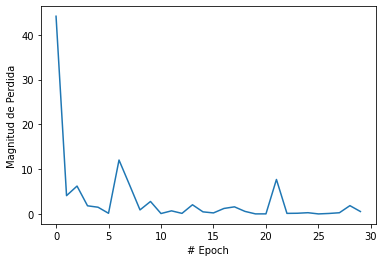

In [33]:
# Vemos el resultado de la función de pérdida en cada época:

plt.xlabel("# Epoch")
plt.ylabel("Magnitud de Pérdida")
plt.plot(TrainCnn.history["loss"])

In [37]:
# Exportamos del modelo en archivos h5. Así guardamos los pesos, los sesgos de la
# red y el estado del optimizador para utlizarlo más adelante o en otro proyecto:
# Recordad descargar los archivos a su equipo para volver a subirlos después, ya
# que al finalizar la sesión de Colab estos se perderán.

cnn.save('modelo_cnn.h5')
cnn.save_weights('pesos_cnn.h5')



In [ ]:
#--------------------------------- ATENCION ----------------------------------#
# De ser necesario, acá podemos volver a montar la CNN con los valores del modelo
# y los pesos que habíamos exportado. Así, podemos hacer uso de la red neuronal 
# sin necesidad de volver a entrenarla:

modelo = '/content/modelo_cnn.h5'
pesos_modelo = '/content/pesos_cnn.h5'
cnn = load_model(modelo)
cnn.load_weights(pesos_modelo)

Ingrese un nro del 1 al 180 para seleccionar una imagen y que ésta sea clasificada: 60
(150, 150, 3)
(1, 150, 150, 3)


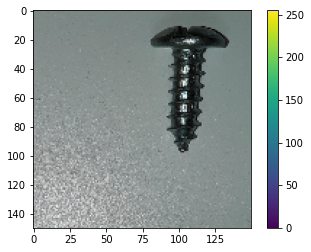

[[0.6139236  0.38607642]]
1.0
0
Esta imagen corresponde a un TORNILLO


In [42]:
# Ahora podemos elegir una imágen de las 180 del dataset y ver su clasificación:

a = int(input("Ingrese un nro del 1 al 180 para seleccionar una imágen y que ésta sea clasificada: "))
imgP = dataImg[a]
print(imgP.shape)
imgP = (np.expand_dims(imgP,0))
print(imgP.shape)

plt.figure()
plt.imshow(dataImg[a])
plt.colorbar()
plt.grid(False)
plt.show()

Predic = cnn.predict(imgP)
print(Predic)
print(np.sum(Predic))
print(np.argmax(Predic))
print("Esta imágen corresponde a un", class_names[np.argmax(Predic)])